In [1]:
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix,greycoprops
import numpy as np
import skimage
import os
import cv2
import time
np.set_printoptions(threshold=np.inf)

In [2]:
def load_images():
    dir = os.path.join(os.sep,'home','mohit','Desktop','dataset')
    images = {}
    for k in range(1,113):
        for i in ['1','2']:
            for j in ['1','2','3','4','5','6','7','8']:
                try:
                    images['c'+str(k)+'_'+i+'_'+j] = cv2.imread(os.path.join(dir,'Cheque'+str(k),i,i+'_'+j+'.tif'))
                    images['c'+str(k)+'_'+i+'_'+j] = cv2.cvtColor(images['c'+str(k)+'_'+i+'_'+j], cv2.COLOR_BGR2YCrCb)
                except:
                    break
    return images       

In [3]:
def calc_glcm(images,dim,dist = [1],angles = [0,np.pi/4,np.pi/2,np.pi/4*3]):    
    glcm_pens = {}
    for k in range(1,113):
        for i in ['1','2']:
            for j in ['1','2','3','4','5','6','7','8']:
                try:
                    glcm_pens['c'+str(k)+'_'+i+'_'+j] = greycomatrix(images['c'+str(k)+'_'+i+'_'+j][:,:,dim], dist, angles,symmetric = 'True')
                    glcm_pens['c'+str(k)+'_'+i+'_'+j][:,:,0,0][255,:] = 0
                    glcm_pens['c'+str(k)+'_'+i+'_'+j][:,:,0,0][:,255] = 0
                    glcm_pens['c'+str(k)+'_'+i+'_'+j][:,:,0,1][255,:] = 0
                    glcm_pens['c'+str(k)+'_'+i+'_'+j][:,:,0,1][:,255] = 0
                    glcm_pens['c'+str(k)+'_'+i+'_'+j][:,:,0,2][255,:] = 0
                    glcm_pens['c'+str(k)+'_'+i+'_'+j][:,:,0,2][:,255] = 0
                    glcm_pens['c'+str(k)+'_'+i+'_'+j][:,:,0,3][255,:] = 0
                    glcm_pens['c'+str(k)+'_'+i+'_'+j][:,:,0,3][:,255] = 0

                    glcm_pens['c'+str(k)+'_'+i+'_'+j] = glcm_pens['c'+str(k)+'_'+i+'_'+j]/np.sum(np.sum(glcm_pens['c'+str(k)+'_'+i+'_'+j])) 
                except:
                    break
    return glcm_pens

In [4]:
def get_p(p):
    N = p.shape[0]
    sumpxy = np.zeros(2*N)
    diffpxy = np.zeros(N)
    for i in range(0,N):
        for j in range(0,N):
            sumpxy[i+j] = sumpxy[i+j]+p[i][j]
            diffpxy[np.abs(i-j)] = diffpxy[np.abs(i-j)]+p[i][j]
            
    return sumpxy,diffpxy

def f4(p,ux,uy):
    N = p.shape[0]
    variance = 0
    for i in range(0,N):
        for j in range(0,N):
            variance+=p[i,j]*(i-ux)*(j-uy)
    return variance        
    
    
    
def _entropy(p):
    p = p.ravel()
    p1 = p.copy()
    p1 += (p==0)
    return -np.dot(np.log2(p1), p)



def glcm_14(cmats,
                    ignore_zeros=False,
                    preserve_haralick_bug=False,
                    compute_14th_feature=False,
                    return_mean=False,
                    return_mean_ptp=False,
                    use_x_minus_y_variance = False,
                    ):
    '''
    features = haralick_features(cmats,
                    ignore_zeros=False,
                    preserve_haralick_bug=False,
                    compute_14th_feature=False,
                    return_mean=False,
                    return_mean_ptp=False,
                    use_x_minus_y_variance=False,
                    )
    Computers Haralick features for the given cooccurrence matrices.
    This function is not usually necessary, as you can call ``haralick`` with
    an image to obtain features for that image. Use only if you know what you
    are doing.
    Notes
    -----
    Haralick's paper has a typo in one of the equations. This function
    implements the correct feature unless `preserve_haralick_bug` is True. The
    only reason why you'd want the buggy behaviour is if you want to match
    another implementation.
    References
    ----------
    Cite the following reference for these features::
        @article{Haralick1973,
            author = {Haralick, Robert M. and Dinstein, Its'hak and Shanmugam, K.},
            journal = {Ieee Transactions On Systems Man And Cybernetics},
            number = {6},
            pages = {610--621},
            publisher = {IEEE},
            title = {Textural features for image classification},
            url = {http://ieeexplore.ieee.org/lpdocs/epic03/wrapper.htm?arnumber=4309314},
            volume = {3},
            year = {1973}
        }
    Parameters
    ----------
    cmats : sequence of ndarrays
        This should be a sequence of ndarrays, all square and all of the same
        shape.
    ignore_zeros : bool, optional
        Whether to ignore zero pixels (default: False).
    Other Parameters
    ----------------
    preserve_haralick_bug : bool, optional
        whether to replicate Haralick's typo (default: False).
        You probably want to always set this to ``False`` unless you want to
        replicate someone else's wrong implementation.
    compute_14th_feature : bool, optional
        whether to compute & return the 14-th feature
    return_mean : bool, optional
        When set, the function returns the mean across all the directions
        (default: False).
    return_mean_ptp : bool, optional
        When set, the function returns the mean and ptp (point-to-point, i.e.,
        difference between max() and min()) across all the directions (default:
        False).
    use_x_minus_y_variance : bool, optional
        Feature 10 (index 9) has two interpretations, as the variance of |x-y|
        or as the variance of P(|x-y|). In order to achieve compatibility with
        other software and previous versions of mahotas, mahotas defaults to
        using ``VAR[P(|x-y|)]``; if this argument is True, then it uses
        ``VAR[|x-y|]`` (default: False)
    Returns
    -------
    feats : ndarray of np.double
        A 4x13 or 4x14 feature vector (one row per direction) if `f` is 2D,
        13x13 or 13x14 if it is 3D. The exact number of features depends on the
        value of ``compute_14th_feature`` Also, if either ``return_mean`` or
        ``return_mean_ptp`` is set, then a single dimensional array is
        returned.
    See Also
    --------
    haralick : function
        compute Haralick features for an image
    '''
    if return_mean and return_mean_ptp:
        raise ValueError("mahotas.haralick_features: Cannot set both `return_mean` and `return_mean_ptp`")
    features = []
    for cmat in cmats:
        feats = np.zeros(13 + bool(compute_14th_feature), np.double)
        if ignore_zeros:
            cmat[0] = 0
            cmat[:,0] = 0
        T = cmat.sum()
        if not T:
            raise ValueError('mahotas.haralick_features: the input is empty. Cannot compute features!\n' +
                                'This can happen if you are using `ignore_zeros`' )
        if not len(features):
            maxv = len(cmat)
            k = np.arange(maxv)
            k2 = k**2
            tk = np.arange(2*maxv)
            tk2 = tk**2
            i,j = np.mgrid[:maxv,:maxv]
            ij = i*j
            i_j2_p1 = (i - j)**2
            i_j2_p1 += 1
            i_j2_p1 = 1. / i_j2_p1
            i_j2_p1 = i_j2_p1.ravel()
            px_plus_y = np.empty(2*maxv, np.double)
            px_minus_y = np.empty(maxv, np.double)
        elif maxv != len(cmat):
            raise ValueError('mahotas.haralick_features: All cmatrices must be of the same size')

        p = cmat / float(T)
        pravel = p.ravel()
        px = p.sum(0)
        py = p.sum(1)

        ux = np.dot(px, k)
        uy = np.dot(py, k)
        vx = np.dot(px, k2) - ux**2
        vy = np.dot(py, k2) - uy**2

        sx = np.sqrt(vx)
        sy = np.sqrt(vy)
        px_plus_y.fill(0)
        px_minus_y.fill(0)
       # _texture.compute_plus_minus(p, px_plus_y, px_minus_y)
        px_plus_y, px_minus_y = get_p(p)
        feats[0] = np.dot(pravel, pravel)
        feats[1] = np.dot(k2, px_minus_y)

        if sx == 0. or sy == 0.:
            feats[2] = 1.
        else:
            feats[2] = (1. / sx / sy) * (np.dot(ij.ravel(), pravel) - ux * uy)

        #feats[3] = vx
        feats[3] = f4(p,ux,uy)
        feats[4] = np.dot(i_j2_p1, pravel)
        feats[5] = np.dot(tk, px_plus_y)

        feats[7] = _entropy(px_plus_y)

        # There is some confusion w.r.t. feats[6].
        #
        # Haralick's paper uses feats[7] in its computation, but it is
        # clear that feats[5] should be used (i.e., it computes a
        # variance).
        #
        if preserve_haralick_bug:
            feats[6] = ((tk-feats[7])**2*px_plus_y).sum()
        else:
            feats[6] = np.dot(tk2, px_plus_y) - feats[5]**2

        feats[ 8] = _entropy(pravel)
        #if use_x_minus_y_variance:
        mu_x_minus_y = np.dot(px_minus_y, k)
        mu_x_minus_y_sq = np.dot(px_minus_y, k2)
        feats[ 9] = mu_x_minus_y_sq - mu_x_minus_y**2
        #else:
        #    feats[ 9] = px_minus_y.var()
        feats[10] = _entropy(px_minus_y)

        HX = _entropy(px)
        HY = _entropy(py)
        crosspxpy = np.outer(px,py)
        crosspxpy += (crosspxpy == 0) # This makes log(0) become log(1), and thus evaluate to zero, such that everything works below:
        crosspxpy = crosspxpy.ravel()
        HXY1 = -np.dot(pravel, np.log2(crosspxpy))
        HXY2 = _entropy(crosspxpy)

        if max(HX, HY) == 0.:
            feats[11] = (feats[8]-HXY1)
        else:
            feats[11] = (feats[8]-HXY1)/max(HX,HY)
        feats[12] = np.sqrt(max(0,1 - np.exp( -2. * (HXY2 - feats[8]))))

        if compute_14th_feature:
            # Square root of the second largest eigenvalue of the correlation matrix
            # Probably the faster way to do this is just SVD the whole (likely rank deficient) matrix
            # grab the second highest singular value . . . Instead, we just amputate the empty rows/cols and move on.
            nzero_rc = px != 0
            nz_pmat = p[nzero_rc,:][:,nzero_rc] # Symmetric, so this is ok!
            if nz_pmat.shape[0] > 2:
                ccm = np.corrcoef(nz_pmat)
                e_vals = np.linalg.eigvalsh(ccm)
                e_vals.sort()
                feats[13] = np.sqrt(e_vals[-2])
            else:
                feats[13] = 0
        features.append(feats)

    features = np.array(features)
    if return_mean:
        return features.mean(axis=0)
    if return_mean_ptp:
        mean = features.mean(axis=0)
        ptp = features.ptp(axis=0)
        std = features.std(axis=0)
        return np.concatenate((mean,ptp))

    return features


In [5]:
def calc_glcm_prop(glcm_pens):
    properties = {}
    for k in range(1,113):
        for i in ['1','2']:
            for j in ['1','2','3','4','5','6','7','8']:
                try:
                    print(k)
                    properties['c'+str(k)+'_'+i+'_'+j] = glcm_14([glcm_pens['c'+str(k)+'_'+i+'_'+j][:,:,0,0],glcm_pens['c'+str(k)+'_'+i+'_'+j][:,:,0,1],glcm_pens['c'+str(k)+'_'+i+'_'+j][:,:,0,2],glcm_pens['c'+str(k)+'_'+i+'_'+j][:,:,0,3]],return_mean_ptp=True)
                except:
                    break    
    return properties

In [6]:
def dist(param1,param2,n1,n2):
    mean1 = np.mean(param1)
    mean2 = np.mean(param2)
    var1  = np.var(param1)
    var2 = np.var(param2)
     
    d = np.abs(mean1-mean2)
    d/=(var1/n1 + var2/n2)**0.5
    
    return d


def distance(fv1,fv2):
    return ((fv1-fv2)**2)/(fv1+fv2)


def distance_distribution(features):
    same_pens = {}
    diff_pens = {}
    
    for k in range(1,113) :
        for i in ['1','2']: 
            for n in ['1','2']:
                for j in ['1','2','3','4','5','6','7','8'] :
                    for m in ['1','2','3','4','5','6','7','8'] :
                        try:
                            if(i==n and j==m):
                                continue    
                            elif i==n and 'c_'+str(k)+'_'+n+'_'+m+'::'+i+'_'+j not in same_pens:
                                same_pens['c_'+str(k)+'_'+i+'_'+j+'::'+n+'_'+m] = distance(features['c'+str(k)+'_'+i+'_'+j],features['c'+str(k)+'_'+n+'_'+m])
                                #print(' same {}   :{}'.format('c_'+str(k)+'_'+i+'_'+j+'::'+n+'_'+m,same_pens['c_'+str(k)+'_'+i+'_'+j+'::'+n+'_'+m]))
                    
                            elif i!=n and 'c_'+str(k)+'_'+n+'_'+m+'::'+i+'_'+j not in diff_pens :
                                diff_pens['c_'+str(k)+'_'+i+'_'+j+'::'+n+'_'+m] = distance(features['c'+str(k)+'_'+i+'_'+j],features['c'+str(k)+'_'+n+'_'+m])
                                #print(' diff {}   :{}'.format('c_'+str(k)+'_'+i+'_'+j+'::'+n+'_'+m,diff_pens['c_'+str(k)+'_'+i+'_'+j+'::'+n+'_'+m]))
                        except:
                            
                            pass
     
    print('Lengths same pens-{} different pens-{}'.format(len(same_pens),len(diff_pens)))
    return same_pens,diff_pens

In [7]:
images = load_images()

In [8]:
glcm_pens_Y  = calc_glcm(images,0)
glcm_pens_Cb = calc_glcm(images,1)
glcm_pens_Cr = calc_glcm(images,2)


In [10]:
start = time.time()
features_Y = calc_glcm_prop(glcm_pens_Y)
features_Cb = calc_glcm_prop(glcm_pens_Cb)
features_Cr = calc_glcm_prop(glcm_pens_Cr)
time.time()-start

1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
25
25
25
25
25
25
25
25
25
25
25
25
26
26
26
26
26
26
26
26
26
26
27
27
27
27
27
27
27
27
27
27
28
28
28
28
28
28
28
28
28
29
29
29
29
29
29
29
29
29
29
30
30
30
30
30
30
30
30
30
31
31
31
31
31
31
31
31
31
31
32
32
32
32
32
32
32
32
32
32
32
33
33
33
33
33
33
33
33
33
33
34
34
34
34
34
34
34
34
34
34
35
35
35
35
35
35
35
35
35
35
35
36
36
36
36
36
36
36
36
36
36
36
37
37
37
37
37
37
37

60
60
60
60
60
60
60
60
61
61
61
61
61
61
61
61
61
61
61
62
62
62
62
62
62
62
62
62
62
62
62
63
63
63
63
63
63
63
63
63
63
63
63
64
64
64
64
64
64
64
64
64
64
65
65
65
65
65
65
65
65
65
65
66
66
66
66
66
66
66
66
67
67
67
67
67
67
67
67
68
68
68
68
68
68
68
68
68
68
69
69
69
69
69
69
69
69
70
70
70
70
70
70
70
70
70
71
71
71
71
71
71
71
71
72
72
72
72
72
72
72
72
73
73
73
73
73
73
73
73
74
74
74
74
74
74
74
74
75
75
75
75
75
75
75
75
75
76
76
76
76
76
76
76
76
76
77
77
77
77
77
77
77
77
78
78
78
78
78
78
78
78
78
79
79
79
79
79
79
79
79
79
79
80
80
80
80
80
80
80
80
80
81
81
81
81
81
81
81
81
81
82
82
82
82
82
82
82
82
82
83
83
83
83
83
83
83
83
83
83
83
84
84
84
84
84
84
84
84
85
85
85
85
85
85
85
85
86
86
86
86
86
86
86
86
87
87
87
87
87
87
87
87
88
88
88
88
88
88
88
88
88
88
88
89
89
89
89
89
89
89
89
89
90
90
90
90
90
90
90
90
90
91
91
91
91
91
91
91
91
91
92
92
92
92
92
92
92
92
92
92
93
93
93
93
93
93
93
93
93
94
94
94
94
94
94
94
94
94
94
95
95
95
95
95
95
95
95
95
95
96
96
96
9

1977.7940998077393

In [11]:
same_pens_Y,diff_pens_Y = distance_distribution(features_Y)
same_pens_Y = np.array([v for  v in same_pens_Y.values()])
diff_pens_Y = np.array([v for  v in diff_pens_Y.values()])


Lengths same pens-1465 different pens-1456


In [12]:
same_pens_Cb,diff_pens_Cb = distance_distribution(features_Cb)
same_pens_Cb = np.array([v for  v in same_pens_Cb.values()])
diff_pens_Cb = np.array([v for  v in diff_pens_Cb.values()])

Lengths same pens-1465 different pens-1456


In [13]:
same_pens_Cr,diff_pens_Cr = distance_distribution(features_Cr)
same_pens_Cr = np.array([v for  v in same_pens_Cr.values()])
diff_pens_Cr = np.array([v for  v in diff_pens_Cr.values()])

Lengths same pens-1465 different pens-1456


In [14]:
distances_Y = [] 
for i in range(0,26):
    distances_Y.append(dist(same_pens_Y[:,i],diff_pens_Y[:,i],1465,1456))
distances_Cb = [] 
for i in range(0,26):
    distances_Cb.append(dist(same_pens_Cb[:,i],diff_pens_Cb[:,i],1465,1456))
distances_Cr = [] 
for i in range(0,26):
    distances_Cr.append(dist(same_pens_Cr[:,i],diff_pens_Cr[:,i],1465,1456))

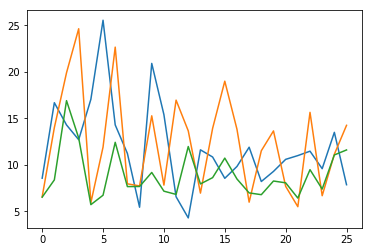

In [15]:
plt.plot(distances_Y,label = 'x')
plt.plot(distances_Cb,label = 'y')
plt.plot(distances_Cr,label = 'z')

In [16]:
import pandas as pd
Y = pd.DataFrame(features_Y)
CB = pd.DataFrame(features_Cb)
CR = pd.DataFrame(features_Cr)
glcm_features_all = pd.concat([Y,CB,CR])
glcm_features_all

,c100_1_1,c100_1_2,c100_1_3,c100_1_4,c100_2_1,c100_2_2,c100_2_3,c101_1_1,c101_1_2,c101_1_3,...,c99_2_3,c9_1_1,c9_1_2,c9_1_3,c9_1_4,c9_1_5,c9_1_6,c9_1_7,c9_2_1,c9_2_2
0,0.000418,0.000514,0.000587,0.000339,0.000386,0.000480,0.000709,0.000562,0.000726,0.000855,...,0.000682,0.001070,0.000553,0.000616,0.000470,0.000278,0.000462,0.000313,0.000904,0.000384
1,958.860720,911.502438,992.375613,979.099797,1764.552935,1829.315780,1854.487381,1407.718303,1394.465080,1502.294155,...,2040.480344,791.612769,909.473512,1125.234066,1029.614510,1167.817801,1106.669534,1009.382501,1172.512848,1120.909478
2,0.272580,0.343392,0.374409,0.304421,0.214561,0.249565,0.249783,0.344433,0.342782,0.297526,...,0.151027,0.387566,0.403251,0.499124,0.508989,0.500553,0.411988,0.501667,0.492740,0.424042
3,178.902406,237.959759,296.593262,214.237673,242.034295,303.703468,308.347796,369.493873,362.386410,317.556128,...,185.160851,249.247097,305.348805,558.952004,532.089659,583.254714,387.462956,507.237644,568.566861,413.714900
4,0.049333,0.050444,0.050598,0.050026,0.048190,0.062362,0.065157,0.071917,0.079801,0.073752,...,0.048550,0.051091,0.046291,0.041021,0.050066,0.045643,0.047926,0.046346,0.054700,0.056804
5,137.658997,144.018704,129.503144,140.316276,82.041390,77.188933,74.303321,74.795613,71.817706,70.959082,...,75.847598,173.495098,152.852597,148.581624,144.923832,141.578143,148.027779,147.209341,121.201215,128.438125
6,1674.470344,1863.341474,2178.748660,1836.050487,2732.690115,3044.129653,3087.878565,2885.693794,2844.010720,2772.518665,...,2781.123747,1788.601158,2130.868731,3361.042080,3157.973145,3500.836655,2656.521356,3038.333079,3446.780292,2775.769078
7,7.290762,7.304795,7.397070,7.377522,7.482577,7.501029,7.443513,7.492570,7.433175,7.377435,...,7.330816,7.124813,7.385301,7.628996,7.654980,7.792081,7.556860,7.705069,7.477754,7.606188
8,11.439885,11.077319,10.859629,11.748126,11.561513,11.362444,10.971925,11.456663,11.204640,10.853790,...,10.673737,9.932911,10.931343,10.739403,11.164374,11.958236,11.174693,11.774940,10.196141,11.514021
9,419.676289,404.692594,435.728993,433.140095,833.247406,917.608895,939.436653,729.337656,759.159624,781.474650,...,936.728142,312.904304,353.154497,448.458885,402.560491,460.258197,446.952452,396.299242,511.614219,473.252191


In [17]:
glcm_features_all.to_csv('/home/mohit/Desktop/featuresUpdated/GLCM_mean_ptp.csv', sep=',')